Jonathan McEntee - September 9th 2018

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import timeit
import graphviz
import warnings

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, validation_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

warnings.filterwarnings("once")

# Blood Transfusion Data Set

The first data set I train the models on come from the donor database of a blood transfusion center in Taiwan. The database includes data used to construct features the models can train on:

- recency is the number of months since the donor last made a donation
- frequency is the total number of donations they've made
- monetary is the total blood they've donated in c.c. (this has a correlation of 1 with frequency)
- time is the number of months since their first donation

Finally there is a binary variable indicating if the donor donated blood in March 2007. We were asked to pick two interesting data sets for this assignment. I find the blood transfusion set interesting because through it we can attempt to predict the turnout of donors. Turnout prediction is a key problem in a number of fields, and one I'm eager to work on.

In [2]:
blood_data = pd.read_csv('transfusions.csv')
boolean_to_string = lambda x : 'Yes' if x is 1 else 'No'
blood_data["donated_blood"] = blood_data.donated_blood.apply(boolean_to_string)
blood_data.head()

,recency,frequency,monetary,time,donated_blood
0,2,50,12500,98,Yes
1,0,13,3250,28,Yes
2,1,16,4000,35,Yes
3,2,20,5000,45,Yes
4,1,24,6000,77,No


In [3]:
blood_data.donated_blood.value_counts()

No     570
Yes    178
Name: donated_blood, dtype: int64

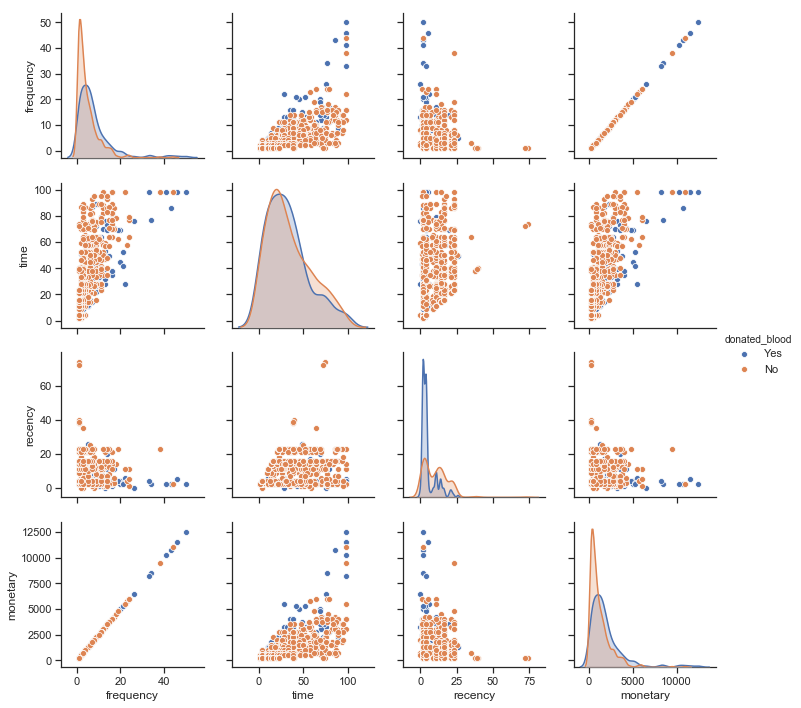

In [4]:
sns.set(style='ticks')
sns.pairplot(blood_data, hue='donated_blood', vars=['frequency', 'time', 'recency', 'monetary'])

In [5]:
y = blood_data["donated_blood"]
X = blood_data.drop(["donated_blood", "monetary"], axis=1)

There are a lot of duplicate values within the data causing noise

In [6]:
duplicates = X[X.duplicated()]
duplicates.sort_values(by=list(duplicates.columns)).head()

,recency,frequency,time
154,2,1,2
155,2,1,2
156,2,1,2
157,2,1,2
158,2,1,2


In [7]:
non_duplicates = y.index.difference(duplicates.index)
y_nd = y.iloc[non_duplicates]
X_nd = X.iloc[non_duplicates]

In [8]:
y_nd.value_counts()

No     371
Yes    131
Name: donated_blood, dtype: int64

In [9]:
y_train_nd, y_test_nd = train_test_split(y_nd, test_size=0.1, stratify=y_nd, random_state=42)
X_train_nd, X_test_nd = train_test_split(X_nd, test_size=0.1, stratify=y_nd, random_state=42)

## Create Test and Training Sets

10% of the data was withheld and put into a test set. The remaining 90% was placed in the training set to be fed into our models. The entire dataset contains 748 samples including 570 positive samples (people who donated blood in March 2007) and 178 negative samples. As the classes are somewhat unbalanced, I decided to stratify the test train split.

In [11]:
y_train, y_test = train_test_split(y, test_size=0.1, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.1, stratify=y, random_state=42)

## Functions

In [12]:
def learning_curve_dataframe(estimator, X, y, train_sizes=np.linspace(.1, 1.0, 10),
                             cv=None, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    test_score_df = pd.DataFrame(dict(train_sizes=train_sizes,
                                      score_mean=np.mean(train_scores, axis=1),
                                      score_std=np.std(train_scores, axis=1),
                                      score_type="Training score"))
    
    train_score_df = pd.DataFrame(dict(train_sizes=train_sizes,
                                       score_mean=np.mean(test_scores, axis=1),
                                       score_std=np.std(test_scores, axis=1),
                                       score_type="Cross-validation score"))
    
    return pd.concat([test_score_df, train_score_df])

def plot_learning_curve(title, df, ylim=None):
    """
    taken from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    
    training_score = df[df.score_type == "Training score"]
    train_sizes = training_score.train_sizes
    train_scores_mean = training_score.score_mean
    train_scores_std = training_score.score_std
    
    test_score = df[df.score_type == "Cross-validation score"]
    test_scores_mean = test_score.score_mean
    test_scores_std = test_score.score_std
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def validation_curve_dataframe(estimator, X, y, cv=None, n_jobs=-1, param_name=None,
                               param_range=np.linspace(1, 100, 10), alternative_x_axis=None):
    
    x_axis = alternative_x_axis if alternative_x_axis is not None else param_range
    
    train_scores, test_scores = validation_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, param_name=param_name,
        param_range=param_range)
    
    test_score_df = pd.DataFrame(dict(parameter_setting=x_axis,
                                      score_mean=np.mean(train_scores, axis=1),
                                      score_std=np.std(train_scores, axis=1),
                                      score_type="Training score",
                                      graph_type="Validation Curve"))
    
    train_score_df = pd.DataFrame(dict(parameter_setting=x_axis,
                                       score_mean=np.mean(test_scores, axis=1),
                                       score_std=np.std(test_scores, axis=1),
                                       score_type="Cross-validation score",
                                       graph_type="Validation Curve"))
    
    return pd.concat([test_score_df, train_score_df])

def plot_validation_curve(title, df, ylim=None, xlab=None, log=False):
    
    training_score = df[df.score_type == "Training score"]
    x_axis = training_score.parameter_setting
    train_scores_mean = training_score.score_mean
    train_scores_std = training_score.score_std
    
    test_score = df[df.score_type == "Cross-validation score"]
    test_scores_mean = test_score.score_mean
    test_scores_std = test_score.score_std
    
    xlab = "Parameter Setting" if xlab is None else xlab
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlab)
    plt.ylabel("Score")
    plt.grid()

    if log:
        plt.xscale("log")
    
    plt.fill_between(x_axis, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(x_axis, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(x_axis, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(x_axis, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


## Using a Decision Tree Classifier

The decision tree, like all the other models I trained for this paper, was taken from the scikit-learn package available for python. The decision tree here is based on the CART algorithm. Rather than entropy, a gini score is used to choose where to split the data. The decision tree can train on both categorical and numerical features.

I began my analysis by performing a grid search over the hyperparameters max_depth and min_samples_split to see which produced the highest cross-validation score (10 folds). The decision tree will not split the data more than max_depth-times down any individual branch. min_samples_split is the mininum number of samples needed in a node for it to be split into a new branch. Setting these parameters is equivalent to pre-pruning the tree. The values max_depth = 3 and min_samples_split = 140 appear to produce the highest cross-validation score, so we'll use those as a starting point.

In [12]:
parameters = {
    'max_depth' : list(range(1, 30, 2)),
    'min_samples_split' : list(range(20, 1000, 10))
}

decision_tree = DecisionTreeClassifier()
clf = GridSearchCV(decision_tree, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 3, 'min_samples_split': 140}

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

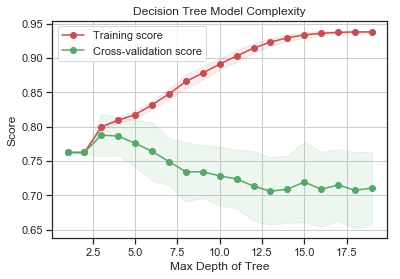

In [147]:
# built in validation curve
clf = DecisionTreeClassifier(min_samples_split=2)
df = validation_curve_dataframe(estimator=clf, X=X_train, y=y_train, cv=10,
                                param_name='max_depth', param_range=range(1, 20))
validation_dataframes = df.assign(model_name='Decision Tree', parameter_name='Max Depth of Tree')
plot_validation_curve(title="Decision Tree Model Complexity", df=df,
                     xlab="Max Depth of Tree")

As the max_depth of the decision tree increases, the training score moves asymptotically towards about 93% accuracy. Meanwhile the cross-validation score peaks at 3 or 4 depth and then plummets from there. From this graph it's apparent that the algorithm is able to construct trees that better fit the training data as max_depth grows past 4, but those increasingly elaborate trees do not generalize well. Which is exactly what we expect to see.

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

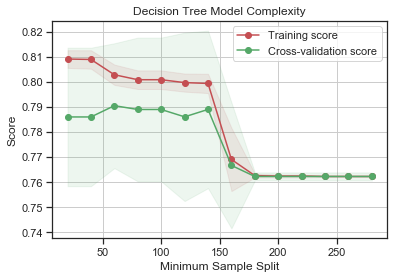

In [101]:
clf = DecisionTreeClassifier(max_depth=4)
df = validation_curve_dataframe(estimator=clf,
                           X=X_train, y=y_train, param_name='min_samples_split',
                           param_range=range(20, 300, 20), cv=10)
validation_dataframes = pd.concat([df.assign(model_name='Decision Tree', parameter_name='Minimum Sample Split'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="Decision Tree Model Complexity", xlab="Minimum Sample Split", df=df)

The min_samples_split parameter on the other hand, seems to perform roughly the same for any setting below 150 samples, after which both training and cross-validation scores plummet. It seems the model needs the flexibility to split sample sets as small as 150 to properly fit the model.

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

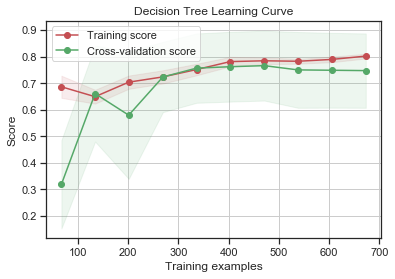

In [102]:
clf = DecisionTreeClassifier(max_depth=4, min_samples_split=60)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
learning_curve_dataframes = df.assign(model_name="Decision Tree")
plot_learning_curve(title="Decision Tree Learning Curve", df=df)

The learning curve for the decision tree shows both the training and cross-validation scores steadily increasing as more samples are made available. The training curve grow at roughly the same rate, showing that the gains made by having more training data are generalizing reasonably well, but the variance of the cross-validation score also remains high.

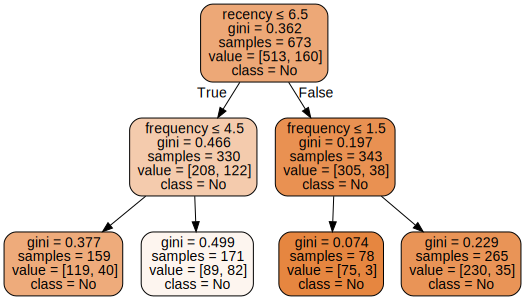

In [16]:
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=40)
clf.fit(X_train, y_train)
dot_data = export_graphviz(clf, out_file=None,  
                         feature_names=X.columns,
                         class_names = ['No', 'Yes'],
                         filled=True, rounded=True,  
                         special_characters=True)  

graphviz.Source(dot_data)

Out of curiousity, I trained a small decision tree (max_depth = 2) on the training data and constructed a graph of it using graphviz. This allows us to see how the decision tree is dividing the data. We can see that donors who have donated recently (less than 7 months before) had a high probability (~89%) of donating blood in March 2007. If they have furthermore, not made more than a single donation in the past, that probability rises to 96%.

In [12]:
start = timeit.default_timer()
clf = DecisionTreeClassifier(max_depth=4, min_samples_split=60)
clf.fit(X_train, y_train)
decision_tree_train_time = timeit.default_timer() - start
decision_tree_train_time

0.00435284900595434

In [13]:
start = timeit.default_timer()
decision_tree_score = clf.score(X_test, y_test)
decision_tree_score_time = timeit.default_timer() - start
decision_tree_score_time

0.0052026810008101165

In [14]:
model_scores = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                             'score_value': [decision_tree_train_time,
                                             decision_tree_score_time,
                                             decision_tree_score],
                             'model' : 'Decision Tree'
                            })

In [126]:
model_scores

,score_type,score_value,model
0,Training Time,0.004430,Decision Tree
1,Scoring Time,0.001795,Decision Tree
2,Accuracy,0.773333,Decision Tree


## Using K Nearest Neighbors

In [19]:
parameters = {
    'n_neighbors' : list(range(1, 30)),
    'weights' : ['uniform', 'distance'],
    "p" : [1, 2]
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}

Our grid search suggests that the best parameters for our model are setting n_neighbors = 16, p = 2 (euclidean distance), and weights = 'uniform' (no distance weighting). We'll use these parameters as a starting point

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

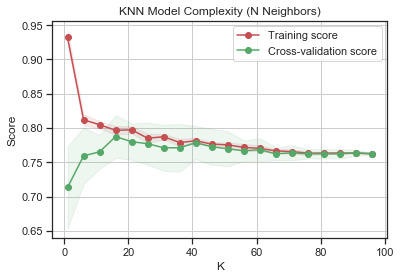

In [103]:
clf = KNeighborsClassifier(p=2)
df = validation_curve_dataframe(estimator=clf,
                                X=X_train, y=y_train,
                                param_name='n_neighbors', param_range=range(1, 100, 5),
                                cv=10)
validation_dataframes = pd.concat([df.assign(model_name='K Nearest Neighbors', parameter_name='K'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="KNN Model Complexity (N Neighbors)", df=df, xlab="K")

As we increase K the training score falls and the cross-validation score rises, until K reaches about 40, at which point cross-validation begins to fall as well. As K increases so does the bias of the model, and ultimately the scores converge. This plot suggests our grid search chose an appropriate value for k_neighbors.

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

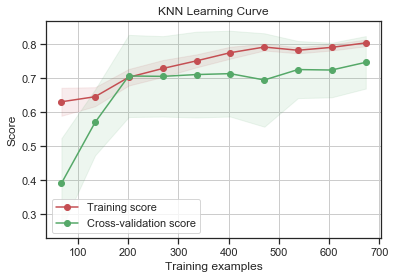

In [104]:
# the built in learning curve
clf = KNeighborsClassifier(p=2, n_neighbors=15)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
learning_curve_dataframes = pd.concat([df.assign(model_name="K Nearest Neighbors"),
                                       learning_curve_dataframes], sort=True)
plot_learning_curve(title="KNN Learning Curve", df=df)

The learning curve is similar to the decision tree. The cross-validation score rises with the training score, which shows that model is not overfitting, but the cross-validation score's variance is high.

In [15]:
start = timeit.default_timer()
clf = KNeighborsClassifier(p=2, n_neighbors=15)
clf.fit(X_train, y_train)
knn_train_time = timeit.default_timer() - start
knn_train_time

0.0034114870068151504

In [16]:
start = timeit.default_timer()
knn_score = clf.score(X_test, y_test)
knn_score_time = timeit.default_timer() - start
knn_score_time

0.004214099986711517

In [17]:
df = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                   'score_value': [knn_train_time,
                                   knn_score_time,
                                   knn_score],
                   'model' : 'K Nearest Neighbors'
                  })
model_scores = pd.concat([model_scores, df])

## Using AdaBoost

In [24]:
parameters = {
    'n_estimators' : list(range(20, 80)),
    'learning_rate' : [10**x for x in range(-1, 2)],
}

ada_booster = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=70))
clf = GridSearchCV(ada_booster, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'learning_rate': 0.1, 'n_estimators': 32}

Running a gridsearch for the AdaBoost model gives us learning_rate = 0.1 and n_estimators = 29 as optimal parameters. We set our decision tree parameters at max_depth = 4, min_samples_split = 40, the same parameters we chose for our final model before.

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

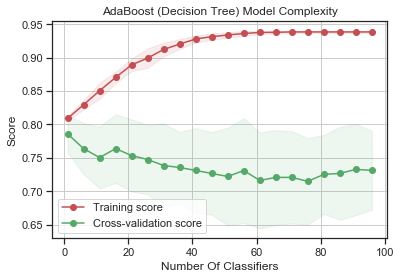

In [105]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=40), learning_rate=1)
df = validation_curve_dataframe(estimator=clf,
                                X=X_train, y=y_train,
                                param_name='n_estimators', param_range=range(1, 100, 5),
                                cv=10)
validation_dataframes = pd.concat([df.assign(model_name='AdaBoost', parameter_name='Number of Classifiers'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="AdaBoost (Decision Tree) Model Complexity", df=df,
                      xlab="Number Of Classifiers")

Surprisingly a single decision tree appears to perform better than multiple boosted trees. As the number of estimators increases, the training score rises, but the cross-validation score falls. This signals that the model overfits with more estimators.

A brief aside: the AdaBoost model should be able to perfectly fit the training data with enough estimators. So why does it asymptotically approach 93%? It turns out that about 30% of the dataset have features that are exactly the same, but some of these samples with identical features will have a different classification. As such, there are "two versions of the truth" on a large percentage of the data.

I thought this problematic data might be behind the AdaBoost model performing more poorly than the decision tree, but removing the data and retraining the model produces a similar result.

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

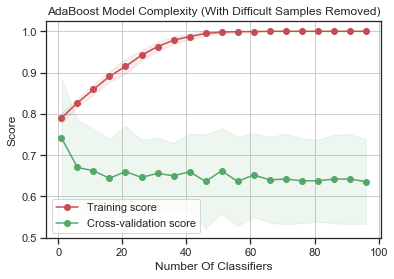

In [106]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=40), learning_rate=1)
df = validation_curve_dataframe(estimator=clf, X=X_nd, y=y_nd, cv=10,
                                param_name='n_estimators', param_range=range(1, 100, 5))
validation_dataframes = pd.concat([df.assign(model_name='AdaBoost',
                                             parameter_name='Number of Classifiers (With Difficult Samples Removed)'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="AdaBoost Model Complexity (With Difficult Samples Removed)", df=df,
                      xlab="Number Of Classifiers")

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

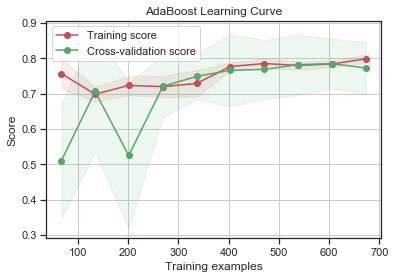

In [107]:
# the built in learning curve
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_split=20),
                         learning_rate=1, n_estimators=3)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
learning_curve_dataframes = pd.concat([df.assign(model_name="AdaBoost"),
                                       learning_curve_dataframes], sort=True)
plot_learning_curve(title="AdaBoost Learning Curve", df=df)

The learning curve shows the training score and cross validation score converge within 300 samples. By 500 samples the scores seem to have stopped rising.

In [18]:
start = timeit.default_timer()
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_split=20),
                         learning_rate=1, n_estimators=3)
clf.fit(X_train, y_train)
adaboost_train_time = timeit.default_timer() - start
adaboost_train_time

0.016643567010760307

In [19]:
start = timeit.default_timer()
adaboost_score = clf.score(X_test, y_test)
adaboost_score_time = timeit.default_timer() - start
adaboost_score_time

0.002595564001239836

In [20]:
df = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                   'score_value': [adaboost_train_time,
                                   adaboost_score_time,
                                   adaboost_score],
                   'model' : 'AdaBoost'
                  })
model_scores = pd.concat([model_scores, df])

## Using a Neural Net

In [30]:
parameters = {
    'hidden_layer_sizes' : [tuple([x] * n) for x in range(10,100,10) for n in range(1,5)],
    'max_iter' : range(200, 500, 100)
}

# 'max_iter' : range(200, 500, 50),

mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'hidden_layer_sizes': (40,), 'max_iter': 200}

Our grid search over the neural net algorithm gives us the starting parameters of max_iter = 300 (max iterations) and hidden_layer_sizes = (80, 80, 80) (three hidden layers with 80 nodes each).

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

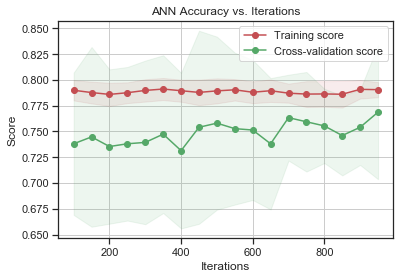

In [14]:
clf = MLPClassifier(hidden_layer_sizes=(80, 80, 80), tol=1e-1000)
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y,
                                param_name='max_iter', param_range=range(100, 1000, 50),
                                cv=10)
#validation_dataframes = pd.concat([df.assign(model_name='Neural Net', parameter_name='Iterations'),
#                                   validation_dataframes], sort=True)
plot_validation_curve(title="ANN Accuracy vs. Iterations", df=df,
                      xlab="Iterations")

However, when we scan over different values of max_iter and the scores it produces, we find no apparent rising or falling trend.

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (650) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (650) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (650) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

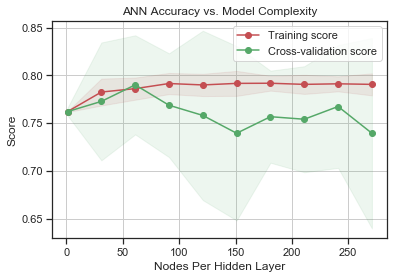

In [109]:
clf = MLPClassifier(max_iter=650)
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y,
                                param_name='hidden_layer_sizes',
                                param_range=[tuple([x] * 3) for x in range(1, 300, 30)],
                                alternative_x_axis=range(1, 300, 30), cv=10)
validation_dataframes = pd.concat([df.assign(model_name='Neural Net', parameter_name='Nodes Per Hidden Layer'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="ANN Accuracy vs. Model Complexity", df=df,
                      xlab="Nodes Per Hidden Layer")

I want to try different layer sizes for my neural net, so I set the NN to have 3 hidden layers, and set the layers per node to different values to see how the scoring changed. But again, there no apparent relationship between more nodes and accuracy. I decided to stick with the parameters given by the grid search.

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

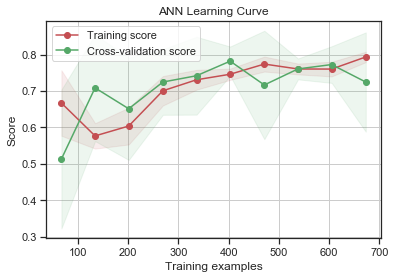

In [110]:
# the built in learning curve
clf = MLPClassifier(hidden_layer_sizes=(80, 80, 80), max_iter=300)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
learning_curve_dataframes = pd.concat([df.assign(model_name="Neural Net"),
                                       learning_curve_dataframes], sort=True)
plot_learning_curve(title="ANN Learning Curve", df=df)

The learning curve is similar to other models we've trained so far. The training and cross-validation scores rise together. At first rapidly and then leveling off.

In [31]:
start = timeit.default_timer()
clf = MLPClassifier(hidden_layer_sizes=(80, 80, 80), max_iter=300)
clf.fit(X_train, y_train)
ann_train_time = timeit.default_timer() - start
ann_train_time

0.11706278400379233

In [32]:
clf

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(80, 80, 80), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [22]:
start = timeit.default_timer()
ann_score = clf.score(X_test, y_test)
ann_score_time = timeit.default_timer() - start
ann_score_time

0.002858949010260403

In [23]:
df = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                   'score_value': [ann_train_time,
                                   ann_score_time,
                                   ann_score],
                   'model' : 'Neural Net'
                  })
model_scores = pd.concat([model_scores, df])

## Using a Support Vector Machine (rbf)

In [36]:
parameters = {
    'C' : [10**x for x in range(-3, 5)],
    'kernel' : ['rbf'],
    'gamma' : [10**x for x in range(-3, 5)]
}

svc = SVC()
clf = GridSearchCV(svc, parameters, cv=10)
clf.fit(X_train_nd, y_train_nd)
clf.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

A grid search suggests using a radial basis function kernel, with C = 100 and gamme = 0.001.

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

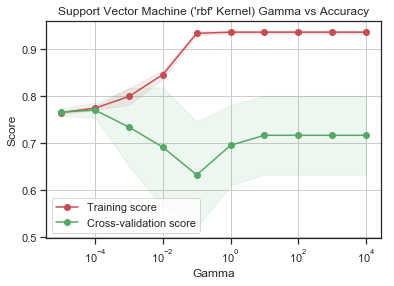

In [111]:
clf = SVC(kernel='rbf', C=100)
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y, cv=10, param_name='gamma',
                                param_range=[10**x for x in range(-5, 5)])
validation_dataframes = pd.concat([df.assign(model_name='SVM ("rbf" Kernel)', parameter_name='Gamma'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="Support Vector Machine ('rbf' Kernel) Gamma vs Accuracy", df=df,
                      xlab="Gamma", log=True)

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

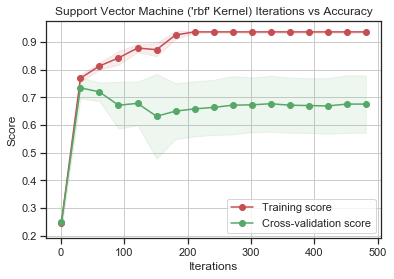

In [112]:
warnings.filterwarnings("ignore")
clf = SVC(kernel='rbf', C=100)
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y, cv=10, param_name='max_iter',
                                param_range=range(1, 500, 30))
validation_dataframes = pd.concat([df.assign(model_name='SVM ("rbf" Kernel)', parameter_name='Iterations'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="Support Vector Machine ('rbf' Kernel) Iterations vs Accuracy", df=df,
                      xlab="Iterations")

In [113]:
warnings.filterwarnings("once")

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

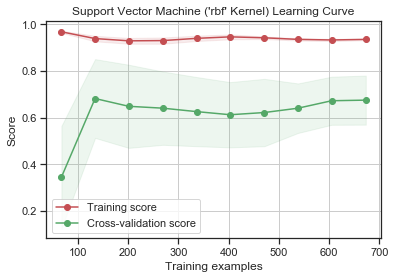

In [114]:
clf = SVC(kernel='rbf', C=100)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
learning_curve_dataframes = pd.concat([df.assign(model_name='Support Vector Machine (RBF)'),
                                       learning_curve_dataframes], sort=True)
plot_learning_curve(title="Support Vector Machine ('rbf' Kernel) Learning Curve", df=df)

In [24]:
start = timeit.default_timer()
clf = SVC(kernel='rbf', C=100)
clf.fit(X_train, y_train)
svm_rbf_train_time = timeit.default_timer() - start
svm_rbf_train_time

0.025136054027825594

In [25]:
start = timeit.default_timer()
svm_rbf_score = clf.score(X_test, y_test)
svm_rbf_score_time = timeit.default_timer() - start
svm_rbf_score_time

0.003995100996689871

In [26]:
df = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                   'score_value': [svm_rbf_train_time,
                                   svm_rbf_score_time,
                                   svm_rbf_score],
                   'model' : 'Support Vector Machine (RBF)'
                  })
model_scores = pd.concat([model_scores, df])

## Using a Support Vector Machine (linear)

In [43]:
parameters = {
    'C' : [10**x for x in range(-5, 5)]
}

lsvc = LinearSVC()
clf = GridSearchCV(lsvc, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'C': 0.0001}

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

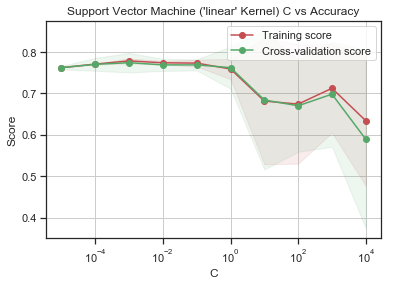

In [115]:
clf = LinearSVC()
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y, cv=10, param_name='C',
                                param_range=[10**x for x in range(-5, 5)])
validation_dataframes = pd.concat([df.assign(model_name='SVM ("linear" Kernel)', parameter_name='C'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="Support Vector Machine ('linear' Kernel) C vs Accuracy", df=df,
                      xlab="C", log=True)

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

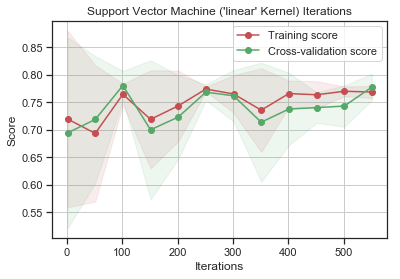

In [151]:
clf = LinearSVC(C=0.1)
df = validation_curve_dataframe(estimator=clf,
                                X=X, y=y, cv=10, param_name='max_iter',
                                param_range=range(1, 600, 50))
validation_dataframes = pd.concat([df.assign(model_name='SVM ("linear" Kernel)', parameter_name='Iterations'),
                                   validation_dataframes], sort=True)
plot_validation_curve(title="Support Vector Machine ('linear' Kernel) Iterations", df=df,
                      xlab="Iterations")

<module 'matplotlib.pyplot' from '/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

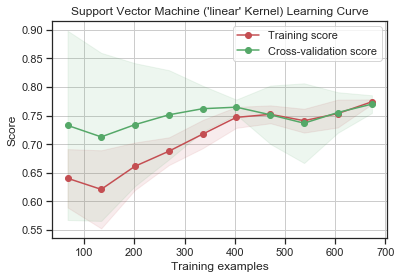

In [117]:
clf = LinearSVC(C=0.1)
df = learning_curve_dataframe(estimator=clf, X=X, y=y, cv=10)
learning_curve_dataframes = pd.concat([df.assign(model_name='Support Vector Machine (Linear)'),
                                       learning_curve_dataframes], sort=True)
plot_learning_curve(title="Support Vector Machine ('linear' Kernel) Learning Curve", df=df)

In [27]:
start = timeit.default_timer()
clf = LinearSVC(C=0.1)
clf.fit(X_train, y_train)
svm_linear_train_time = timeit.default_timer() - start
svm_linear_train_time

0.03224391900585033

In [28]:
start = timeit.default_timer()
svm_linear_score = clf.score(X_test, y_test)
svm_linear_score_time = timeit.default_timer() - start
svm_linear_score_time

0.0018320359813515097

In [29]:
df = pd.DataFrame({'score_type' : ['Training Time', 'Scoring Time', 'Accuracy'],
                   'score_value': [svm_linear_train_time,
                                   svm_linear_score_time,
                                   svm_linear_score],
                   'model' : 'Support Vector Machine (Linear)'
                  })
model_scores = pd.concat([model_scores, df])

## Exporting The Data

In [122]:
validation_dataframes.to_csv('blood_validation.csv', index=False)

In [123]:
learning_curve_dataframes.to_csv('blood_learning_curves.csv', index=False)

In [135]:
model_scores.to_csv('blood_model_scores.csv', index=False)

In [30]:
model_scores

,score_type,score_value,model
0,Training Time,0.004353,Decision Tree
1,Scoring Time,0.005203,Decision Tree
2,Accuracy,0.773333,Decision Tree
0,Training Time,0.003411,K Nearest Neighbors
1,Scoring Time,0.004214,K Nearest Neighbors
2,Accuracy,0.786667,K Nearest Neighbors
0,Training Time,0.016644,AdaBoost
1,Scoring Time,0.002596,AdaBoost
2,Accuracy,0.773333,AdaBoost
0,Training Time,0.269730,Neural Net
